In [8]:
import numpy as np
from numpy import newaxis as NA
import numpy.linalg as la
import matplotlib.pyplot as plt

# Solving nonlinear eq. in 1D

# a. Lennard Jones Energy 

In [9]:
sigma, epsilon = 3.401, 0.997

In [7]:
def distance(points):
    """Calculates Euclidean distanve between N points. Points is an Nx3 array."""
    displacement = points[:,NA]-points[NA,:] #(N,N,3) displacement vector
    return np.sqrt( np.sum(displacement*displacement , axis=-1) )

In [10]:
def div_0(a,b):
    """Divides a by b. If b==0 returns 0."""
    return np.divide(a, b, out=np.zeros_like(b), where=b!=0)

In [11]:
def LJ(sigma, epsilon):
    """Creates the function V which computes the LJ potential with specified\
    sigma and epsilon."""
    def V(points):
        """Returns the Energy of N particle system given coordinates (Nx3) in the\
        Lennard Jones potential."""
        r = distance(points)
        N = len(r)
        #take only upper triangular part of the matrix since dist(ij)=dist(ji)
        r = np.triu(r)
        return np.sum(4*epsilon*((div_0(sigma,r))**12-(div_0(sigma,r))**6))
    return V

In [94]:
N, dim, n_atoms = 200, 3, 4
range0 = np.linspace(3,11,N)
Points = np.zeros((N,n_atoms,dim))
Points[:,0,0] = range0
Points[:,2,0] = 14
Points[:,3,[0,1]] = [7,3.2]
E2, E4 = np.empty(shape = N), np.empty(shape = N)
V = LJ(sigma, epsilon)
for i in range(N): #Computing LJ energy for N coordinates
    E2[i] = V(Points[i,:2,:])
    E4[i] = V(Points[i,:,:])

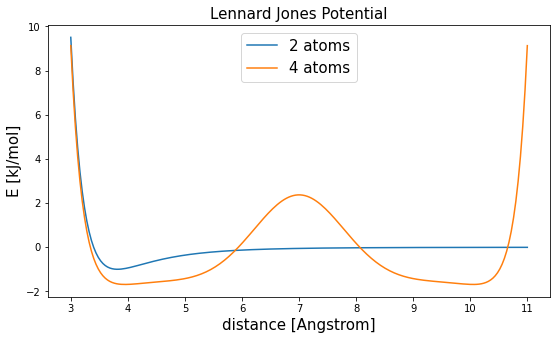

In [89]:
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(range0, E2, label = '2 atoms'), ax.plot(range0, E4, label = '4 atoms')
ax.set_ylabel('E [kJ/mol]', fontsize = 15), ax.legend(fontsize = 15)
ax.set_xlabel(r'distance [Angstrom]', fontsize = 15)
ax.set_title(r'Lennard Jones Potential', fontsize = 15)
plt.show()

# b. Bisection Method

In [95]:
def bis(f,a,b,tol):
    """Bisection method for finding roots of a funciton f given an interval [a,b]\
    where sign(f(a))!=sign(f(b)). The function returns the root within the given tolerance 
    and the number of function calls."""
    n_calls = int(np.log2((b-a)/tol))
    x = (a+b)/2
    fb = f(b)
    fa = f(a)
    for i in range(n_calls):
        fx = f(x)
        if np.sign(fx)==np.sign(fa):
            a = x
        else:
            b = x
        x = (a+b)/2
    return x, n_calls

In [96]:
def Vx(x):
    """Helper function to call V with a range of different x in the 1d case."""
    p0 = np.zeros((1,3))
    p1 = np.reshape(np.array([0,0,x]), (1,3))
    return V(np.concatenate((p0,p1),axis = 0))

x_root,n = bis(Vx,2,6,1e-13)
x_root, n, Vx(x_root)

(3.4010000000000105, 45, -7.438316629304609e-14)

45 function calls are necessary 

# c. Newton Raphson method

In [97]:
def DV(r,sigma = sigma, epsilon = epsilon):
    """Derivative of the LJ potential."""
    return 4*epsilon*(6*sigma**6/r**7 - 12*sigma**12/r**13)

In [98]:
def newton_root(f, df, x0, tolerance, max_iterations):
    """Newton-Rhapson method to find root of a function f. Returns root within tolerance\
    and number of function calls."""
    f0 = f(x0)
    n_calls = 0
    while (abs(f0)>tolerance) and (n_calls<max_iterations):
        n_calls+=1
        x0 = x0-f0/df(x0)
        f0 = f(x0)
    return x0, 2*n_calls

newton_root(Vx, DV, 2, 1e-12,100)

(3.400999999999998, 24)

24 function calls are needed 

# d. Combination of NR and bisection method 

In [99]:
def NR_bis(f, df, a, b, x0, tolerance):
    """Combination of Newton Rhapson and bisection which guarantees convergence."""
    f0 = f(x0)
    n_calls = 0
    while abs(f0)>tolerance:
        n_calls += 1
        xn = x0-f0/df(x0) #if new point is outside of (a,b) execute bisection
        if ((xn<a) or (xn>b)):
            n_calls+=2
            fa = f(a)
            x0 = (a+b)/2
            f0 = f(x0)
            if np.sign(f0)==np.sign(fa):
                a = x0
            else:
                b = x0
        else:
            x0 = xn
            n_calls += 1
            f0 = f(x0)
    return x0, n_calls

NR_bis(Vx, DV, 2, 4, 2, 1e-13)

(3.400999999999998, 24)

24 function calls were needed 

# Solving Nonlinear equations in N dimensions

# e. 

In [100]:
def LJgradient(sigma, epsilon):
        """Returns function gradV(X) with given sigma and epsilon."""
        def gradV(X):
            """Given an the coordinates of N points in an (N,3) array returns the gradient\
            in the 3N dimensional space."""
            d = X[:,NA]-X[NA,:] #(N,N,3) displacement vector
            r = np.sqrt(np.sum(d*d , axis=-1)) #(N,N) distances
            np.fill_diagonal(r,1)
            T = 6*sigma**6/(r**7) - 12*sigma**12/(r**13) # (N,N) derivatives matrix
            u = d/r[:,:,NA] #u is (N,N,3) array of unit vectors in dir Xi-Xj
            return 4*epsilon*np.sum(T[:,:,NA]*u, axis = 1)
        return gradV

In [101]:
def gradVx(x):
    """Helper function to call V with a range of different x in the 1d case."""
    p0 = np.zeros((1,3))
    p1 = np.reshape(np.array([0,0,x]), (1,3))
    return gradV(np.concatenate((p0,p1),axis = 0))
range1 = np.linspace(3,10,N)

In [106]:
gradV = LJgradient(sigma,epsilon)
gradient = np.empty(shape = (num_points,2,dim))
for i in range(N):
    gradient[i] = gradVx(range1[i])

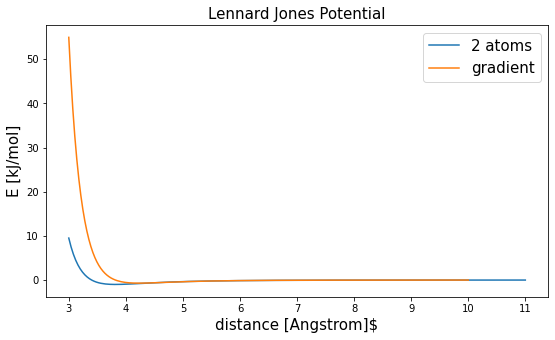

In [109]:
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(range0,E2 , label = '2 atoms')
ax.plot(range1,gradient[:,0,-1], label = 'gradient')
ax.set_ylabel('E [kJ/mol]', fontsize = 15), ax.legend(fontsize = 15)
ax.set_xlabel(r'distance [Angstrom]$', fontsize = 15)
ax.set_title(r'Lennard Jones Potential', fontsize = 15)
plt.show()